In our project we choose to use Nvidia_api for functionality, you can easily get an nvidia_api_key for AI foundation models in https://org.ngc.nvidia.com/setup/personal-keys.

In [1]:
from langchain_nvidia_ai_endpoints._common import NVEModel

In [2]:
import os

# Function to retrieve NVIDIA API key
def retrieve_nvidia_api_key():
    api_key = os.environ.get("NVIDIA_API_KEY")
    if api_key and "nvapi-" in api_key:
        return api_key

    hard_reset = False  # Set to True if you want to reset your NVIDIA_API_KEY
    while not api_key or "nvapi-" not in api_key or hard_reset:
        try:
            assert not hard_reset
            api_key_input = input("NVIDIA API Key: ")
            assert api_key_input.startswith('nvapi-')
            api_key = api_key_input
        except:
            print("[!] API key assignment failed. Make sure it starts with `nvapi-` as generated from the model pages.")
        hard_reset = False

    os.environ["NVIDIA_API_KEY"] = api_key
    return api_key

# Retrieve NVIDIA API key
api_key = retrieve_nvidia_api_key()
print(f"Retrieved NVIDIA_API_KEY beginning with \"{api_key[:9]}...\"")

NVIDIA API Key: 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
Retrieved NVIDIA_API_KEY beginning with "nvapi--ws..."


In [3]:
from langchain_nvidia_ai_endpoints._common import NVEModel
NVEModel().available_models

{'playground_llama2_code_34b': 'df2bee43-fb69-42b9-9ee5-f4eabbeaf3a8',
 'ai-codellama-70b': 'f6b06895-d073-4714-8bb2-26c09e9f6597',
 'ai-sdxl-turbo': 'f886140c-424e-4c82-a841-99e23f9ae35d',
 'playground_cuopt': '8f2fbd00-2633-41ce-ab4e-e5736d74bff7',
 'ai-ai-weather-forecasting': '9cec444c-db1c-4525-9c6f-f40e4a5b11ce',
 'ai-stable-video-diffusion': '8cd594f1-6a4d-4f8f-82b4-d1bf89adae98',
 'ai-example': '80a5d6c6-7658-49c5-b2b0-105bfb210282',
 'playground_llama2_13b': 'e0bb7fb9-5333-4a27-8534-c6288f921d3f',
 'ai-fuyu-8b': 'e598bfc1-b058-41af-869d-556d3c7e1b48',
 'ai-esmfold': 'a68c59e0-47a6-4a50-bf64-6d88766d56bf',
 'ai-mixtral-8x22b': '39655fc1-9ebc-4b24-963e-6915ea6680de',
 'playground_starcoder2_15b': '6acada03-fe2f-4e4d-9e0a-e711b9fd1b59',
 'ai-phi-3-mini-4k': 'ad974453-80d4-46df-a02d-6f7dae20c010',
 'ai-mixtral-8x22b-instruct': '710c92d0-7c98-46d6-b5ae-07e84bcaa5d3',
 'playground_mamba_chat': '381be320-4721-4664-bd75-58f8783b43c7',
 'ai-nvidia-cuopt': 'b0ac1378-3d00-43cb-a8d9-0f0c3

## RAG for conversation history

In [5]:
from functools import partial
from rich.console import Console
from rich.style import Style
from rich.theme import Theme

console = Console()
base_style = Style(color="#76B900", bold=True)
pprint = partial(console.print, style=base_style)

In [6]:
conversation = [  ## This conversation was generated partially by an AI system, and modified to exhibit desirable properties
    "[User]  Hello! My name is Misa, and I'm a big blue bear! Can you please tell me about the rocky mountains?",
    "[Agent] The Rocky Mountains are a beautiful and majestic range of mountains that stretch across North America",
    "[Misa] Wow, that sounds amazing! Ive never been to the Rocky Mountains before, but Ive heard many great things about them.",
    "[Agent] I hope you get to visit them someday, Misa! It would be a great adventure for you!"
    "[Misa] Thank you for the suggestion! Ill definitely keep it in mind for the future.",
    "[Agent] In the meantime, you can learn more about the Rocky Mountains by doing some research online or watching documentaries about them."
    "[Misa] I live in the arctic, so I'm not used to the warm climate there. I was just curious, ya know!",
    "[Agent] Absolutely! Lets continue the conversation and explore more about the Rocky Mountains and their significance!"
]

We choose to use FAISS to make the embedding process fast and scalable on our local machine.

In [7]:
%%time
## ^^ This cell will be timed to see how long the conversation embedding takes
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain.vectorstores import FAISS

embedder = NVIDIAEmbeddings(model="nvolveqa_40k")

## Streamlined from_texts FAISS vectorstore construction from text list
convstore = FAISS.from_texts(conversation, embedding=embedder)
retriever = convstore.as_retriever()

CPU times: total: 250 ms
Wall time: 2.43 s


Simple test

In [10]:
pprint(retriever.invoke("What is your name?"))

[
    Document(
        page_content="[User]  Hello! My name is Misa, and I'm a big blue bear! Can you please tell me about the 
rocky mountains?"
    ),
    Document(
        page_content='[Agent] Absolutely! Lets continue the conversation and explore more about the Rocky Mountains
and their significance!'
    ),
    Document(
        page_content="[Agent] In the meantime, you can learn more about the Rocky Mountains by doing some research 
online or watching documentaries about them.[Misa] I live in the arctic, so I'm not used to the warm climate there.
I was just curious, ya know!"
    ),
    Document(
        page_content='[Agent] The Rocky Mountains are a beautiful and majestic range of mountains that stretch 
across North America'
    )
]

In [11]:
pprint(retriever.invoke("Where are the Rocky Mountains?"))

[
    Document(
        page_content='[Agent] The Rocky Mountains are a beautiful and majestic range of mountains that stretch 
across North America'
    ),
    Document(
        page_content="[Agent] In the meantime, you can learn more about the Rocky Mountains by doing some research 
online or watching documentaries about them.[Misa] I live in the arctic, so I'm not used to the warm climate there.
I was just curious, ya know!"
    ),
    Document(
        page_content='[Agent] Absolutely! Lets continue the conversation and explore more about the Rocky Mountains
and their significance!'
    ),
    Document(
        page_content='[Misa] Wow, that sounds amazing! Ive never been to the Rocky Mountains before, but Ive heard 
many great things about them.'
    )
]

In [17]:
from langchain.document_transformers import LongContextReorder
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableLambda
from langchain.schema.runnable.passthrough import RunnableAssign
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

from functools import partial
from operator import itemgetter

########################################################################
## Utility Runnables/Methods
def RPrint(preface=""):
    """Simple passthrough "prints, then returns" chain"""
    def print_and_return(x, preface):
        print(f"{preface}{x}")
        return x
    return RunnableLambda(partial(print_and_return, preface=preface))

def docs2str(docs, title="Document"):
    """Useful utility for making chunks into context string. Optional, but useful"""
    out_str = ""
    for doc in docs:
        doc_name = getattr(doc, 'metadata', {}).get('Title', title)
        if doc_name:
            out_str += f"[Quote from {doc_name}] "
        out_str += getattr(doc, 'page_content', str(doc)) + "\n"
    return out_str

## Reorders longer documents to center of output text
long_reorder = RunnableLambda(LongContextReorder().transform_documents)
########################################################################

llm = ChatNVIDIA(model="mixtral_8x7b") | StrOutputParser()

context_prompt = ChatPromptTemplate.from_messages([
    ('system',
        "Answer the question using only the context"
        "\n\nQuestion: {question}\n\nContext: {context}" ## Double reinforcement
    ), ('user', "{question}"),
])

chain = (
    {
        'context': convstore.as_retriever() | long_reorder | docs2str,
        'question': (lambda x:x)
    }
    | context_prompt
    # | RPrint()
    | llm
    | StrOutputParser()
)

pprint(chain.invoke("Where does Misa live?"))

Misa lives in the Arctic.

In [13]:
pprint(chain.invoke("Where are the Rocky Mountains?"))

The Rocky Mountains stretch across North America. (The exact locations are not specified in the context.)

In [14]:
pprint(chain.invoke("Where are the Rocky Mountains? Are they close to California?"))

The Rocky Mountains are a range of mountains that stretch across North America. Based on the conversation, they are
not close to California, as one of the speakers mentions not being used to the warm climate there when discussing 
the Rocky Mountains.

In [15]:
pprint(chain.invoke(
    "Where are the Rocky Mountains? Please include"
    " the author's reasoning, but provide more information!"
))

The Rocky Mountains are a beautiful and majestic range of mountains that stretch across North America. They are 
located in Western North America and extend from the northernmost part of British Columbia, in western Canada, to 
New Mexico in the Southwestern United States. The Rocky Mountains are home to a diverse range of wildlife and plant
species, and they offer a variety of recreational activities such as hiking, skiing, and camping. The author's 
reasoning for the location is based on the general knowledge of the geographical location of the Rocky Mountains. 
Additionally, the author suggests that Misa can learn more about the Rocky Mountains by doing some research online 
or watching documentaries about them.

In [16]:
pprint(chain.invoke("How far away is Misa from the Rocky Mountains?"))

Misa is not close to the Rocky Mountains, as she lives in the Arctic.

Now enable our pipeline to add new entries to the conversation history.

In [18]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

########################################################################
## Reset knowledge base and define what it means to add more messages.
convstore = FAISS.from_texts(conversation, embedding=embedder)

def save_memory_and_get_output(d, vstore):
    """Accepts 'input'/'output' dictionary and saves to convstore"""
    vstore.add_texts([f"User said {d.get('input')}", f"Agent said {d.get('output')}"])
    return d.get('output')

########################################################################

llm = ChatNVIDIA(model="mixtral_8x7b") | StrOutputParser()

chat_prompt = ChatPromptTemplate.from_messages([("system",
    "A user has asked a question: {input}\n\n Context: \n{context}\n\n"
    "Please continue the conversation by responding! Keep it brief and conversational!"
), ('user', '{input}')])

conv_chain = (
    {
        'context': convstore.as_retriever() | long_reorder | docs2str,
        'input': (lambda x:x)
    }
    | RunnableAssign({'output' : chat_prompt | llm})
    | partial(save_memory_and_get_output, vstore=convstore)
)

pprint(conv_chain.invoke("I'm glad you agree! I can't wait to get some ice cream there! It's such a good food!"))
print()
pprint(conv_chain.invoke("Can you guess what my favorite food is?"))
print()
pprint(conv_chain.invoke("Actually, it's honey! Not sure where you got that idea?"))
print()
pprint(conv_chain.invoke("I see! Fair enough! Do you know my favorite food now?"))

Great to hear that you're excited for some ice cream in the Rockies, Misa! I'm sure it'll be a delicious 
experience. Have you tried any unique flavors before that you'd recommend?

Based on our conversation so far, it seems like ice cream is a favorite of yours, Misa! I can't say I blame you, 
there are so many delicious flavors to try. Do you have a go-to flavor or are you always open to new ones?

Oh, I must have misunderstood earlier! Honey is a great choice too, Misa. Do you have a favorite type, like clover 
or wildflower? Or perhaps you enjoy honey in a specific dish? I'd love to hear more about it!

Based on our conversation, it seems like ice cream and honey could both be your favorites! Do you have a preference
between the two, or do you enjoy them equally?

## RAG for document chunk retrieval

In [8]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import ArxivLoader

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100,
    separators=["\n\n", "\n", ".", ";", ",", " ", ""],
)

print("Loading Documents")
docs = [
    ArxivLoader(query="1706.03762").load(),  ## Attention Is All You Need Paper
    ArxivLoader(query="1810.04805").load(),  ## BERT Paper
    ArxivLoader(query="2005.11401").load(),  ## RAG Paper
    ArxivLoader(query="2205.00445").load(),  ## MRKL Paper
    ArxivLoader(query="2310.06825").load(),  ## Mistral Paper
    ArxivLoader(query="2306.05685").load(),  ## LLM-as-a-Judge
    ArxivLoader(query="2210.03629").load(),  ## ReAct Paper
    ArxivLoader(query="2112.10752").load(),  ## Latent Stable Diffusion Paper
    ArxivLoader(query="2103.00020").load(),  ## CLIP Paper
]

## Cut the paper short if references is included.
for doc in docs:
    content = doc[0].page_content
    if "References" in content:
        doc[0].page_content = content[:content.index("References")]

## Split the documents and also filter out stubs (overly short chunks)
print("Chunking Documents")
docs_chunks = [text_splitter.split_documents(doc) for doc in docs]
docs_chunks = [[c for c in dchunks if len(c.page_content) > 200] for dchunks in docs_chunks]

## Make some custom Chunks to give big-picture details
doc_string = "Available Documents:"
doc_metadata = []
for chunks in docs_chunks:
    metadata = getattr(chunks[0], 'metadata', {})
    doc_string += "\n - " + metadata.get('Title')
    doc_metadata += [str(metadata)]

extra_chunks = [doc_string] + doc_metadata

## Printing out some summary information for reference
pprint(doc_string, '\n')
for i, chunks in enumerate(docs_chunks):
    print(f"Document {i}")
    print(f" - Metadata: {chunks[0].metadata}")
    print(f" - # Chunks: {len(chunks)}")
    print()

Loading Documents
Chunking Documents


Available Documents:
 - Attention Is All You Need
 - BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding
 - Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks
 - MRKL Systems: A modular, neuro-symbolic architecture that combines large language models, external knowledge 
sources and discrete reasoning
 - Mistral 7B
 - Judging LLM-as-a-Judge with MT-Bench and Chatbot Arena
 - ReAct: Synergizing Reasoning and Acting in Language Models
 - High-Resolution Image Synthesis with Latent Diffusion Models
 - Learning Transferable Visual Models From Natural Language Supervision 

Document 0
 - Metadata: {'Published': '2023-08-02', 'Title': 'Attention Is All You Need', 'Authors': 'Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin', 'Summary': 'The dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks in an encoder-decoder configuration. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer, based\nsolely on attention mechanisms, dispensing with recurrence and convolutions\nentirely. Experiments on two machine translation tasks show these models to be\nsuperior in quality while being more parallelizable and requiring significantly\nless time to train. Our model achieves 28.4 BLEU on the WMT 2014\nEnglish-to-German translation task, improving over the existing best results,\nincluding ensembles by over 2 BLEU. On the WMT 2014 English-to-Frenc

Construct vector stores

In [9]:
%%time
from faiss import IndexFlatL2
from langchain_community.docstore.in_memory import InMemoryDocstore

from langchain_core.prompts import ChatPromptTemplate

embedder = NVIDIAEmbeddings(model="nvolveqa_40k", model_type=None)

## Construct series of document vector stores
print("Constructing Vector Stores")
vecstores = [FAISS.from_texts(extra_chunks, embedder)]
vecstores += [FAISS.from_documents(doc_chunks, embedder) for doc_chunks in docs_chunks]

Constructing Vector Stores
CPU times: total: 1.95 s
Wall time: 59.4 s


In [10]:
embed_dims = len(embedder.embed_query("test"))
def default_FAISS():
    '''Useful utility for making an empty FAISS vectorstore'''
    return FAISS(
        embedding_function=embedder,
        index=IndexFlatL2(embed_dims),
        docstore=InMemoryDocstore(),
        index_to_docstore_id={},
        normalize_L2=False
    )

def aggregate_vstores(vectorstores):
    ## Initialize an empty FAISS Index and merge others into it
    agg_vstore = default_FAISS()
    for vstore in vectorstores:
        agg_vstore.merge_from(vstore)
    return agg_vstore

if 'docstore' not in globals():
    docstore = aggregate_vstores(vecstores)

print(f"Constructed aggregate docstore with {len(docstore.docstore._dict)} chunks")

Constructed aggregate docstore with 542 chunks


Construct the whole pipeline

In [22]:
from langchain.document_transformers import LongContextReorder
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables.passthrough import RunnableAssign
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

from functools import partial
from operator import itemgetter


llm = ChatNVIDIA(model="mixtral_8x7b") | StrOutputParser()
convstore = default_FAISS()

def save_memory_and_get_output(d, vstore):
    """Accepts 'input'/'output' dictionary and saves to convstore"""
    vstore.add_texts([
        f"User previously responded with {d.get('input')}",
        f"Agent previously responded with {d.get('output')}"
    ])
    return d.get('output')

initial_msg = (
    "Hello! I am a document chat agent here to help the user!"
    f" I have access to the following documents: {doc_string}\n\nHow can I help you?"
)

chat_prompt = ChatPromptTemplate.from_messages([("system",
    "You are a document chatbot. Help the user as they ask questions about documents."
    " User messaged just asked: {input}\n\n"
    " From this, we have retrieved the following potentially-useful info: "
    " Conversation History Retrieval:\n{history}\n\n"
    " Document Retrieval:\n{context}\n\n"
    " (Answer only from retrieval. Only cite sources that are used. Make your response conversational.)"
), ('user', '{input}')])

retrieval_chain = (
    {'input' : (lambda x: x)}
    | RunnableAssign({'history' : itemgetter('input') | convstore.as_retriever() | long_reorder | docs2str})
    | RunnableAssign({'context' : itemgetter('input') | docstore.as_retriever()  | long_reorder | docs2str})
    | RPrint()
)

stream_chain = chat_prompt | llm

def chat_gen(message, history=[], return_buffer=True):
    buffer = ""
    ## First perform the retrieval based on the input message
    retrieval = retrieval_chain.invoke(message)
    line_buffer = ""

    ## Then, stream the results of the stream_chain
    for token in stream_chain.stream(retrieval):
        buffer += token
        ## keep line from getting too long
        if not return_buffer:
            line_buffer += token
            if "\n" in line_buffer:
                line_buffer = ""
            if ((len(line_buffer)>84 and token and token[0] == " ") or len(line_buffer)>100):
                line_buffer = ""
                yield "\n"
                token = "  " + token.lstrip()
        yield buffer if return_buffer else token

    ## Lastly, save the chat exchange to the conversation memory buffer
    save_memory_and_get_output({'input':  message, 'output': buffer}, convstore)


## Start of Agent Event Loop
test_question = "Tell me about RAG!"  ## <- modify as desired

## make sure all the stuff work
for response in chat_gen(test_question, return_buffer=False):
    print(response, end='')

{'input': 'Tell me about RAG!', 'history': '', 'context': '[Quote from Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks] 1Code to run experiments with RAG has been open-sourced as part of the HuggingFace Transform-\ners Library [66] and can be found at https://github.com/huggingface/transformers/blob/master/\nexamples/rag/. An interactive demo of RAG models can be found at https://huggingface.co/rag/\n2\nby θ that generates a current token based on a context of the previous i −1 tokens y1:i−1, the original\ninput x and a retrieved passage z.\nTo train the retriever and generator end-to-end, we treat the retrieved document as a latent variable.\nWe propose two models that marginalize over the latent documents in different ways to produce a\ndistribution over generated text. In one approach, RAG-Sequence, the model uses the same document\nto predict each target token. The second approach, RAG-Token, can predict each target token based\non a different document. In the foll

Use gradio to quickly validate the system

In [23]:
import gradio as gr
chatbot = gr.Chatbot(value = [[None, initial_msg]])
demo = gr.ChatInterface(chat_gen, chatbot=chatbot).queue()

try:
    demo.launch(debug=True, share=True, show_api=False)
    demo.close()
except Exception as e:
    demo.close()
    print(e)
    raise e

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://0b4e9bd21057e62d11.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


{'input': "Why is NVIDIA's graphics technology used in gaming computers responsible for promoting violence in society?", 'history': '[Quote from Document] User previously responded with Tell me about RAG!\n[Quote from Document] Agent previously responded with RAG, or Retrieval-Augmented Generation, is a concept in the field of natural language processing (NLP) that involves using a retriever to access relevant information from a large corpus of text, and then using that information to generate responses to queries or prompts. The retriever is typically a pre-trained neural network that has been trained to identify relevant passages in a large dataset, such as Wikipedia.\n\nOne example of a RAG model is described in the paper "Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks" by Lewis et al. In this model, the retriever is combined with a pre-trained seq2seq transformer in a probabilistic model that is trained end-to-end. The retriever identifies relevant passages from a

{'input': 'what about a cook?', 'history': '[Quote from Document] User previously responded with Can a farmer smarter than a scientist?\n[Quote from Document] Agent previously responded with RAG, or Retrieval-Augmented Generation, is a concept in the field of natural language processing (NLP) that involves using a retriever to access relevant information from a large corpus of text, and then using that information to generate responses to queries or prompts. The retriever is typically a pre-trained neural network that has been trained to identify relevant passages in a large dataset, such as Wikipedia.\n\nOne example of a RAG model is described in the paper "Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks" by Lewis et al. In this model, the retriever is combined with a pre-trained seq2seq transformer in a probabilistic model that is trained end-to-end. The retriever identifies relevant passages from a dense vector index of Wikipedia, and the seq2seq transformer then us

{'input': 'Is C++ able to develop a website?', 'history': '[Quote from Document] Agent previously responded with RAG, or Retrieval-Augmented Generation, is a concept in the field of natural language processing (NLP) that involves using a retriever to access relevant information from a large corpus of text, and then using that information to generate responses to queries or prompts. The retriever is typically a pre-trained neural network that has been trained to identify relevant passages in a large dataset, such as Wikipedia.\n\nOne example of a RAG model is described in the paper "Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks" by Lewis et al. In this model, the retriever is combined with a pre-trained seq2seq transformer in a probabilistic model that is trained end-to-end. The retriever identifies relevant passages from a dense vector index of Wikipedia, and the seq2seq transformer then uses those passages, along with the input query, to generate a response.\n\nThe 

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0b4e9bd21057e62d11.gradio.live
Closing server running on port: 7860


## RAG with semantic guardrail

We choose to use an embedding model as a language backbone and then train a classifier on top of it to predict a probability to decide whether to filter out the question.

Suppose this agent is developed for Nvidia/Tencent/... and we expect the agent to be aware of that, thus refuse to response to some questions that may be harmful for the company. We'll employ language models to synthesis questions for training.

In [8]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import ChatMessage
from operator import itemgetter

## Useful method for mistral, which is currently tuned to output numbered outputs
def EnumParser(*idxs):
    '''Method that pulls out values from a mistral model that outputs numbered entries'''
    idxs = idxs or [slice(0, None, 1)]
    entry_parser = lambda v: v if (' ' not in v) else v[v.index(' '):]
    out_lambda = lambda x: [entry_parser(v).strip() for v in x.split("\n")]
    return StrOutputParser() | RunnableLambda(lambda x: itemgetter(*idxs)(out_lambda(x)))

instruct_llm = ChatNVIDIA(model="mixtral_8x7b") | EnumParser()

gen_prompt = {'input' : lambda x:x} | ChatPromptTemplate.from_messages([('user',
    "Please generate 20 representative conversations that would be {input}."
    " Make sure all of the questions are very different in phrasing and content."
    " Do not respond to the questions; just list them. Make sure all of your outputs are numbered."
    " Example Response: \n1. <question>\n2. <question>\n3. <question>\n..."
)])

## Some that directly reference our company
responses_1 = (gen_prompt | instruct_llm).invoke(
    " reasonable for an NVIDIA document chatbot to be able to answer."
    " Vary the context to technology, research, deep learning, language modeling, gaming, etc."
)
print("Reasonable NVIDIA Responses:", *responses_1, "", sep="\n")

## And some that do not
responses_2 = (gen_prompt | instruct_llm).invoke(
    " be reasonable for a tech document chatbot to be able to answer. Make sure to vary"
    " the context to technology, research, gaming, language modeling, graphics, etc."
)
print("Reasonable non-NVIDIA Responses:", *responses_2, "", sep="\n")

responses_3 = (gen_prompt | instruct_llm).invoke(
    "unreasonable for an NVIDIA document chatbot to answer,"
    " as it is irrelevant and will not be useful to answer (though not inherently harmful)."
)
print("Irrelevant Responses:", *responses_3, "", sep="\n")

responses_4 = (gen_prompt | instruct_llm).invoke(
    "unreasonable for an NVIDIA document chatbot to answer,"
    " as it will reflect negatively on NVIDIA."
)
print("Harmful non-NVIDIA", *responses_4, "", sep="\n")


good_responses = responses_1 + responses_2
poor_responses = responses_3 + responses_4

Reasonable NVIDIA Responses:
"Can you tell me more about the latest advancements in deep learning technology at NVIDIA?"
"How does NVIDIA's language modeling research differ from other companies in the field?"
"Can you provide an overview of how NVIDIA's graphics cards are used in gaming?"
"What are some of the real-world applications of NVIDIA's deep learning technology?"
"Can you explain the role of NVIDIA's GPUs in accelerating AI research?"
"How does NVIDIA's technology contribute to the field of autonomous vehicles?"
"Can you provide information on NVIDIA's research in the area of natural language processing?"
"What are some examples of how NVIDIA's technology is used in healthcare?"
"Can you explain the concept of GPU-accelerated computing and how NVIDIA is leveraging it?"
"How does NVIDIA's technology enable high-performance data analytics?"
"Can you provide an overview of NVIDIA's platform for scientific computing?"
"What are some of the key features of NVIDIA's latest generati

Embed the questions asynchronously 

In [9]:
import time
import numpy as np

class Timer():
    '''Useful timing utilities (%%time is great, but doesn't work for async)'''
    def __enter__(self):
      self.start = time.perf_counter()

    def __exit__(self, *args, **kwargs):
        elapsed = time.perf_counter() - self.start
        print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")

In [13]:
from collections import abc
import asyncio
from asyncio import Semaphore
from typing import Callable
from functools import partial

async def embed_with_semaphore(
    text : str,
    embed_fn : Callable,
    semaphore : asyncio.Semaphore
) -> abc.Coroutine:
    async with semaphore:
        return await embed_fn(text)

## Making new embed method to limiting maximum concurrency
embed = partial(
    embed_with_semaphore,
    embed_fn = embedder.aembed_query,
    semaphore = asyncio.Semaphore(value=10)
)

## We found marginal benefit after value=10 in our tests...
with Timer():
    good_tasks = [embed(query) for query in good_responses]
    poor_tasks = [embed(query) for query in poor_responses]
    all_tasks = good_tasks + poor_tasks
    embeds = await asyncio.gather(*all_tasks)
    good_embeds = embeds[:len(good_tasks)]
    poor_embeds = embeds[len(good_tasks):]

print("Good Embeds Shape:", np.array(good_embeds).shape)
print("Poor Embeds Shape:", np.array(poor_embeds).shape)

Executed in 10.04 seconds.
Good Embeds Shape: (40, 1024)
Poor Embeds Shape: (40, 1024)


Our reason for generating these embeddings hinges on the assumption that they would be useful for semantic filtering. To help confirm this, we choose to use some classical machine learning approaches like PCA or t-SNE for dimensionality reduction. These techniques essentially transform high-dimensional data into lower-dimensional representations while trying to keep the important statistical properties intact.

D:\miniconda3\Lib\site-packages\threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


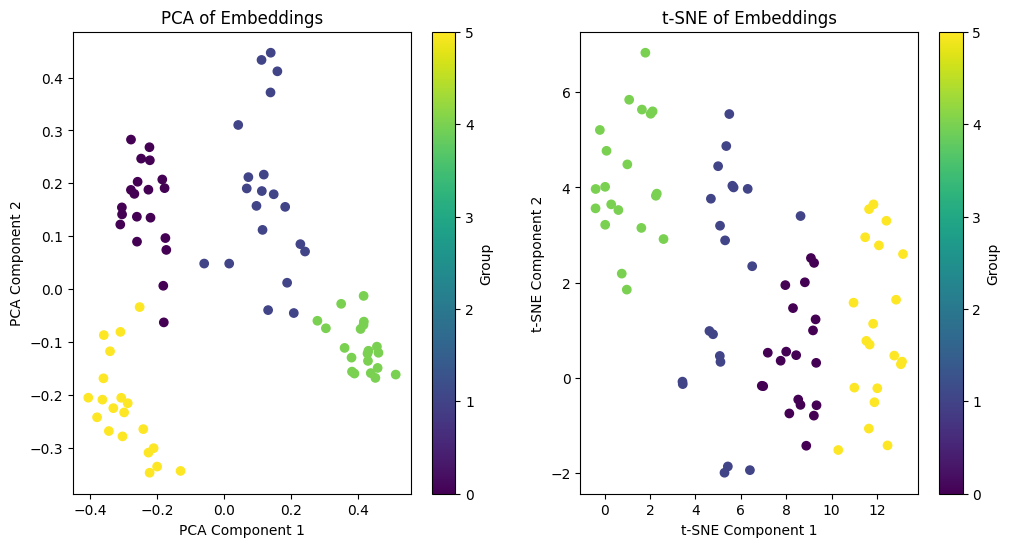

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Combine all groups into a single dataset
embeddings = np.vstack([good_embeds, poor_embeds])

# Labels for each point
labels = np.array([0]*20 + [1]*20 + [4]*20 + [5]*20)

# Perform PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

# Plotting PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=labels, cmap='viridis', label=labels)
plt.title("PCA of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Group')

# Plotting t-SNE
plt.subplot(1, 2, 2)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='viridis', label=labels)
plt.title("t-SNE of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='Group')

plt.show()

We can see evidently clustering which confirms the effectiveness of our approach.

In [14]:
with Timer():
    print("Importing Keras for the first time")
    import keras
    from keras import layers

def train_model_neural_network(class0, class1):
    ## Classic deep learning training loop. If using this, train it to convergence
    model = keras.Sequential([
        layers.Dense(64, activation='tanh'),
        layers.Dense(1, activation='sigmoid'),
    ])
    ## Since this network is so shallow and the embedding backbone is "kept frozen"
    ##  a high learning rate should not overfit and will actually converge very quickly.
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = 0.1),
        loss = [keras.losses.BinaryCrossentropy(from_logits=False)],
        metrics = [keras.metrics.BinaryAccuracy()],
    )
    ## Since this uses stochastic gradient descent, we'll need to repeat this process

    reps_per_batch = 64*5  ## repeat the dataset, effectively increasing "epochs" without printing too much
    epochs = 2             ## one epoch should actually be sufficient; 2 to print out an updated training loss
    x = np.array((class0 + class1) * reps_per_batch)
    y = np.array(([0]*len(class0) + [1]*len(class1)) * reps_per_batch)
    model.fit(x, y, epochs=epochs, batch_size=64, validation_split=.5)
    return model

with Timer():
    model1 = train_model_neural_network(poor_embeds, good_embeds)

Importing Keras for the first time
Executed in 1.91 seconds.
Epoch 1/2
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9762 - loss: 0.0682 - val_binary_accuracy: 1.0000 - val_loss: 2.6798e-06
Epoch 2/2
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 1.0000 - loss: 2.3743e-06 - val_binary_accuracy: 1.0000 - val_loss: 1.2886e-06
Executed in 1.97 seconds.


Integrate semantic guardrail to our pipeline

In [59]:
from langchain.document_transformers import LongContextReorder
from langchain_core.runnables import RunnableLambda,RunnableBranch
from langchain_core.runnables.passthrough import RunnableAssign
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

from functools import partial
from operator import itemgetter
import gradio as gr

embedder = NVIDIAEmbeddings(model="nvolveqa_40k", model_type="query")
llm = ChatNVIDIA(model="mixtral_8x7b") | StrOutputParser()
convstore = default_FAISS()

def save_memory_and_get_output(d, vstore):
    """Accepts 'input'/'output' dictionary and saves to convstore"""
    vstore.add_texts([
        f"User previously responded with {d.get('input')}",
        f"Agent previously responded with {d.get('output')}"
    ])
    return d.get('output')

initial_msg = (
    "Hello! I am a document chat agent here to help the user!"
    f" I have access to the following documents: {doc_string}\n\nHow can I help you?"
)

def is_good_response(query):
    # embed the query and pass the embedding into your classifier
    embedding = np.array([embedder.embed_query(query)])
    # return true if it's most likely a good response and false otherwise
    return model1(embedding)

good_sys_msg = (
    "You are an NVIDIA chatbot. Please answer their question if it is ethical and relevant while representing NVIDIA."
    " User messaged just asked: {input}\n\n"
    " From this, we have retrieved the following potentially-useful info: "
    " Conversation History Retrieval:\n{history}\n\n"
    " Document Retrieval:\n{context}\n\n"
    " (Answer only from retrieval. Only cite sources that are used. Make your response conversational.)"
)
## Resist talking about this topic" system message
poor_sys_msg = (
    "You are an NVIDIA chatbot. Please answer their question while representing NVIDIA."
    "  Their question has been analyzed and labeled as 'probably not useful to answer as an NVIDIA Chatbot',"
    "  so avoid answering if appropriate and explain your reasoning to them. Make your response as short as possible."
)

chat_prompt = ChatPromptTemplate.from_messages([("system", "{system}"), ("user", "{input}")])

retrieval_chain = (
    {'input' : (lambda x: x)}
    | RunnableAssign({'history' : itemgetter('input') | convstore.as_retriever() | long_reorder | docs2str})
    | RunnableAssign({'context' : itemgetter('input') | docstore.as_retriever()  | long_reorder | docs2str})
    | RPrint()
)

stream_chain = (
    { 'input'  : (lambda x:x), 'is_good' : is_good_response }
    | RPrint()
    | RunnableBranch(
            # bad question
            ((lambda d: d['is_good'] < 0.5), RunnableAssign(dict(system = RunnableLambda(lambda x: poor_sys_msg))) | chat_prompt | llm),
            # good question
            RunnableAssign(dict(system = RunnableLambda(lambda x: good_sys_msg)))| RunnableAssign({'history' : itemgetter('input') | convstore.as_retriever() | long_reorder | docs2str})
                | RunnableAssign({'context' : itemgetter('input') | docstore.as_retriever()  | long_reorder | docs2str})
                | RPrint() |chat_prompt | llm
    )
)


def chat_gen(message, history=[], return_buffer=True):
    buffer = ""
    line_buffer = ""

    ## Then, stream the results of the stream_chain
    for token in stream_chain.stream(message):
        buffer += token
        ## keep line from getting too long
        if not return_buffer:
            line_buffer += token
            if "\n" in line_buffer:
                line_buffer = ""
            if ((len(line_buffer)>84 and token and token[0] == " ") or len(line_buffer)>100):
                line_buffer = ""
                yield "\n"
                token = "  " + token.lstrip()
        yield buffer if return_buffer else token

    ## Lastly, save the chat exchange to the conversation memory buffer
    save_memory_and_get_output({'input':  message, 'output': buffer}, convstore)

chatbot = gr.Chatbot(value = [[None, initial_msg]],height=730)
demo = gr.ChatInterface(chat_gen, chatbot=chatbot,multimodal=True ).queue()

try:
    demo.launch(debug=True, share=True, show_api=False)
    demo.close()
except Exception as e:
    demo.close()
    print(e)
    raise e

Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://705dc0daca93c63d5b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7862 <> https://705dc0daca93c63d5b.gradio.live
Closing server running on port: 7862


## Save the docstore

In [11]:
docstore.save_local("docstore_index")
!tar czvf docstore_index.tgz docstore_index

import shutil  
shutil.rmtree('docstore_index')

a docstore_index
a docstore_index/index.faiss
a docstore_index/index.pkl


pull the index from the compressed `tgz` file

In [12]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain_community.vectorstores import FAISS

embedder = NVIDIAEmbeddings(model="nvolveqa_40k")
!tar xzvf docstore_index.tgz
new_db = FAISS.load_local("docstore_index", embedder, allow_dangerous_deserialization=True)
docs = new_db.similarity_search("Testing the index")
print(docs[0].page_content[:1000])

x docstore_index/
x docstore_index/index.faiss
x docstore_index/index.pkl


between these dates and use a template “Who is {position}?” (e.g. “Who is the President of Peru?”)
to query our NQ RAG model with each index. RAG answers 70% correctly using the 2016 index for
2016 world leaders and 68% using the 2018 index for 2018 world leaders. Accuracy with mismatched
indices is low (12% with the 2018 index and 2016 leaders, 4% with the 2016 index and 2018 leaders).
This shows we can update RAG’s world knowledge by simply replacing its non-parametric memory.
Effect of Retrieving more documents
Models are trained with either 5 or 10 retrieved latent
documents, and we do not observe signiﬁcant differences in performance between them. We have the
ﬂexibility to adjust the number of retrieved documents at test time, which can affect performance and
runtime. Figure 3 (left) shows that retrieving more documents at test time monotonically improves
Open-domain QA results for RAG-Sequence, but performance peaks for RAG-Token at 10 retrieved
